In [51]:
import pandas as pd
import pathlib
import bizwiz
import plotly.express as px

path_manager = bizwiz.PathManager(
    data_dir = "../data/electricity_prices"
)




In [201]:
import datetime
import pandas as pd

def get_data_from_sheet_df(df, anchor_text:str, anchor_col_iloc:int):
    """Locate a data section of a sheet using the anchor inputs.
    Then extract the data table
    """
    data_df = df.copy()
    anchor_col_text = data_df.iloc[:,anchor_col_iloc].to_dict()
    anchor_row = None
    for i, text in anchor_col_text.items():
        if text.startswith(anchor_text):
            anchor_row = i
            break
    column_row = anchor_row+1
    data_row = column_row+1
    data_df.columns = data_df.iloc[column_row,:].tolist()
    data_df = data_df.iloc[data_row:,:].copy()
    return data_df

def melt_exchange_df(df):
    # List of columns to use as id variables (in this case, just 'Year')
    id_vars = ['Year']
    # List of columns to melt (all columns except 'Year')
    value_vars = [col for col in df.columns if col != 'Year']
    
    # Perform the melt operation
    melted_df = pd.melt(
        df,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='country',
        value_name='value'
    )
    
    # Add the 'units' column
    melted_df['units'] = 'pound_per_currency'
    # Reorder the columns if desired
    melted_df = melted_df[['Year', 'country', 'value', 'units']]
    return melted_df.copy()

def export_exchange_raw_dataset(df,  export_dir, source_dirname='oecd', printer=None):
    """dump raw CSV file for later
    """
    if printer is None:
        def printer(msg):
            return None 
    source_dir = export_dir / source_dirname
    source_dir.mkdir(parents=True, exist_ok=True)
    printer(f"- export path: '{source_dir.resolve()}'")
    
    date_prefix = datetime.datetime.today().strftime(format="%Y%m%d") #e.g. 20240924
    printer(f"- exporting raw data")
    filepath = source_dir / f"{date_prefix}_exchange_rates.csv"
    df.to_csv(filepath, index=False)
    printer(f"-- export data [{df.shape}]: '{filepath.resolve()}'")
    return True

# Exchange Rates

In [194]:
##### Inputs #####
export_dirname = "20240924_export"

##### Calculation #####
#- setup export location
export_dir = path_manager.data_dir / export_dirname
#create it
export_dir.mkdir(parents=True, exist_ok=True)
print(f"Export path: '{export_dir.resolve()}'")

Export path: '/home/nicholasgrundl/projects/bizwiz/data/electricity_prices/20240924_export'


In [195]:
excel_filename = 'IEA-industrial-electricity-prices.xlsx'
excel_filepath = path_manager.data_dir / excel_filename
print(f"Excel File: '{excel_filepath.resolve()}'")
sheets = pd.read_excel(excel_filepath, sheet_name=None)
sheet_names = list(sheets.keys())
print(f"- workbook contains the following sheets:")
for sheet_name in sheet_names:
    print(f"-- '{sheet_name}'")

Excel File: '/home/nicholasgrundl/projects/bizwiz/data/electricity_prices/IEA-industrial-electricity-prices.xlsx'
- workbook contains the following sheets:
-- 'Cover sheet'
-- 'Contents'
-- 'Table 5.3.1'
-- 'Annual Data OLD'
-- 'Annual  % Changes OLD'
-- '5.3.1 (excl. taxes)'
-- '5.3.1 (inc. taxes)'
-- '5.3.1 (% change excl. taxes)'
-- '5.3.1 (% change inc. taxes)'
-- 'Exchange rates OLD'
-- 'Exchange rates'
-- 'Chart 5.3.1'
-- 'chart_data'


- export path: '/home/nicholasgrundl/projects/bizwiz/data/electricity_prices/20240924_export/oecd'
- exporting raw data
-- export data [(1260, 4)]: '/home/nicholasgrundl/projects/bizwiz/data/electricity_prices/20240924_export/oecd/20240924_exchange_rates.csv'
- successfully exported exchange rate data


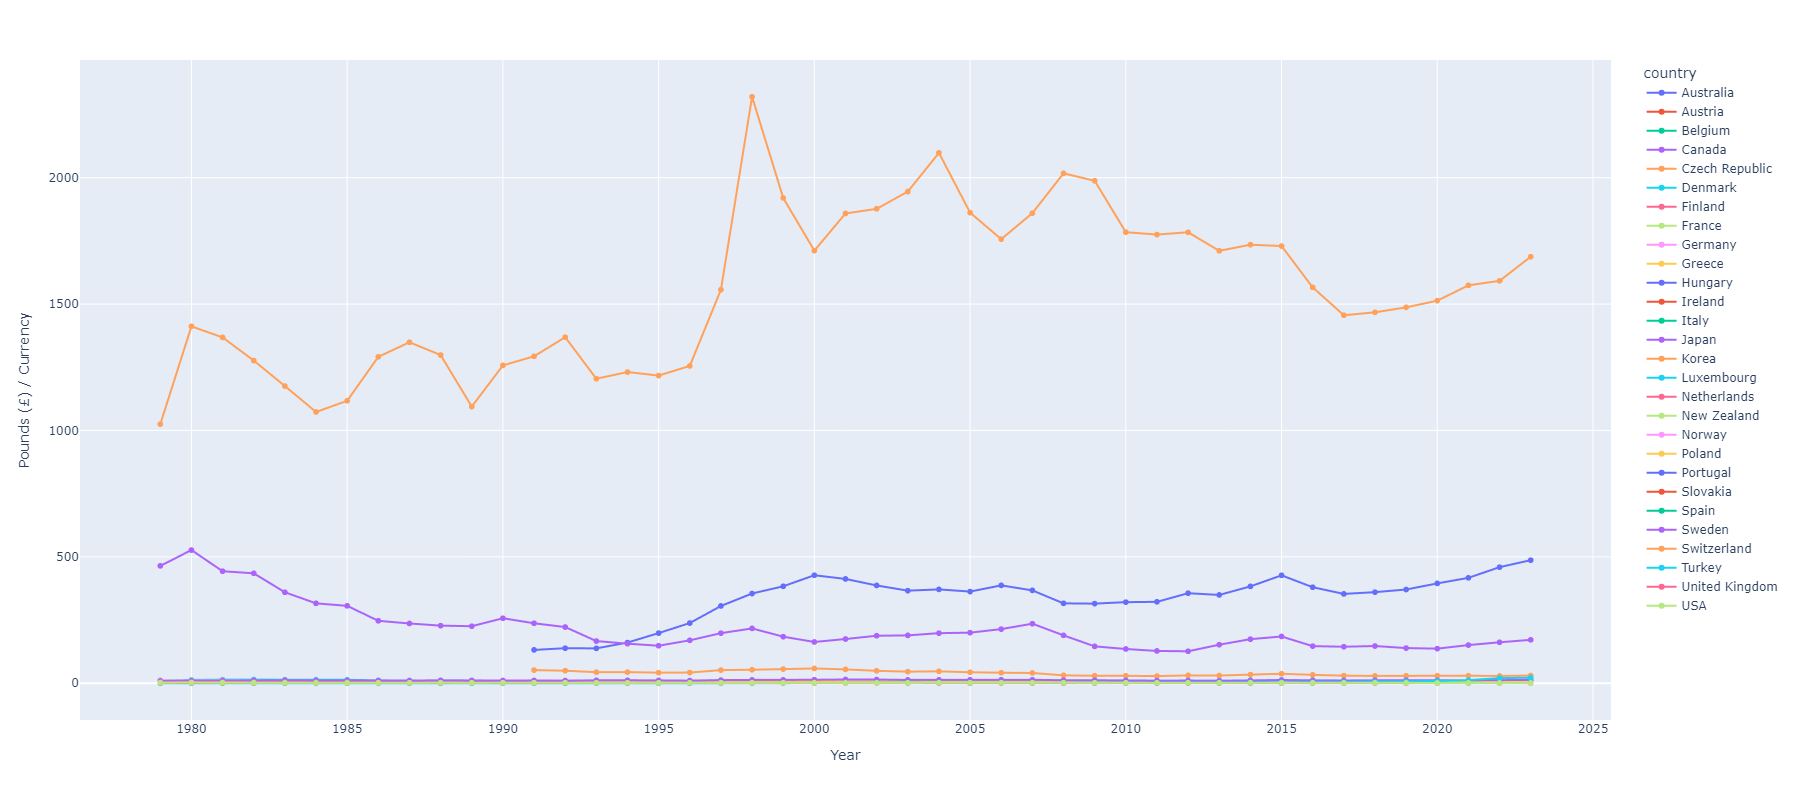

In [197]:
sheet_name = 'Exchange rates'

df = sheets[sheet_name].copy()
df = get_data_from_sheet_df(df, anchor_text='Source', anchor_col_iloc=0)
exchange_df = df.copy()
exchange_df = melt_exchange_df(exchange_df)

#mock a 2023 for now
# - grab from API eventually
new_exchange_data = exchange_df[exchange_df['Year']==2022].copy()
new_exchange_data['Year'] = 2023
new_exchange_data['value'] = new_exchange_data['value']*1.06 #some inflation
exchange_df = pd.concat([exchange_df,new_exchange_data])
#export
export_exchange_raw_dataset(exchange_df,  export_dir, source_dirname='oecd', printer=print)
print(f"- successfully exported exchange rate data")

#visualize
fig = px.line(
    exchange_df, 
    x="Year", y="value", 
    color='country',
    labels= {
        'value' : 'Pounds (£) / Currency'
    },
    height=800, width=1000,
    markers=True,
)
display(fig)

# Electricity Prices

In [199]:
def melt_price_df(df):
    # List of columns to use as id variables (in this case, just 'Year')
    id_vars = ['Customer Size', 'Year']
    # List of columns to melt (all columns except 'Year')
    value_vars = [col for col in df.columns if col not in id_vars]
    
    # Perform the melt operation
    melted_df = pd.melt(
        df,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='country',
        value_name='value'
    )
    
    # Add the 'units' column
    melted_df['units'] = 'pence_per_kwh'
    # Reorder the columns if desired
    melted_df = melted_df[['Year', 'Customer Size', 'country', 'value', 'units']]
    return melted_df.copy()

def manual_field_removal(df, removal_col='country', identifier_string=' '):
    """remove some specific columns"""
    column_values = df[removal_col].unique().tolist()
    values_to_keep = [
        c 
        for c in column_values
        if len(c)==len(c.replace(identifier_string,''))
    ]
    filtered_df = df[df[removal_col].isin(values_to_keep)].copy()
    return filtered_df

def add_currency_value(prices_df, exchange_df, currency_country='USA', converted_name='usd_per_kwh'):
    left_df = prices_df.copy()
    if currency_country not in exchange_df['country'].unique():
        raise KeyError(f"currency_country: '{currency_country}' not found in exchange_df")
    conversion_df = exchange_df[exchange_df['country']==currency_country].copy()
    conversion_df = conversion_df.rename(columns={'value' : 'exchange_rate','units':'exchange_units','country':'exchange_country'})
    df = pd.merge(left=prices_df, right=conversion_df, left_on=['Year'], right_on=['Year'])
    df[converted_name] = df['value']/100/df['exchange_rate']
    return df.copy()

def export_electricity_raw_dataset(df,  export_dir, source_dirname='oecd', printer=None):
    """dump raw CSV file for later
    """
    if printer is None:
        def printer(msg):
            return None 
    source_dir = export_dir / source_dirname
    source_dir.mkdir(parents=True, exist_ok=True)
    printer(f"- export path: '{source_dir.resolve()}'")
    
    date_prefix = datetime.datetime.today().strftime(format="%Y%m%d") #e.g. 20240924
    printer(f"- exporting raw data")
    filepath = source_dir / f"{date_prefix}_electricity_price.csv"
    df.to_csv(filepath, index=False)
    printer(f"-- export data [{df.shape}]: '{filepath.resolve()}'")
    return True

In [200]:
excel_filename = 'IEA-industrial-electricity-prices-quarterly.xlsx'
excel_filepath = path_manager.data_dir / excel_filename
print(f"Excel File: '{excel_filepath.resolve()}'")

sheets = pd.read_excel(excel_filepath, sheet_name=None)
sheet_names = list(sheets.keys())
print(f"- workbook contains the following sheets:")
for sheet_name in sheet_names:
    print(f"-- '{sheet_name}'")

Excel File: '/home/nicholasgrundl/projects/bizwiz/data/electricity_prices/IEA-industrial-electricity-prices-quarterly.xlsx'
- workbook contains the following sheets:
-- 'Cover sheet'
-- 'Contents'
-- 'Annual excl tax'
-- 'Annual incl tax'
-- '5.4.1 (Small excl tax)'
-- '5.4.1 (Small incl tax)'
-- '5.4.2 (Medium excl tax)'
-- '5.4.2 (Medium incl tax)'
-- 'chart_data'
-- '5.4.3 (Large excl tax)'
-- '5.4.3 (Large incl tax)'
-- '5.4.4 (Very Large excl tax)'
-- '5.4.4 (Very Large incl tax)'
-- 'Methodology'
-- 'Charts'


- exporting price data
- export path: '/home/nicholasgrundl/projects/bizwiz/data/electricity_prices/20240924_export/oecd'
- exporting raw data
-- export data [(1728, 9)]: '/home/nicholasgrundl/projects/bizwiz/data/electricity_prices/20240924_export/oecd/20240924_electricity_price.csv'
- successfully exported price data


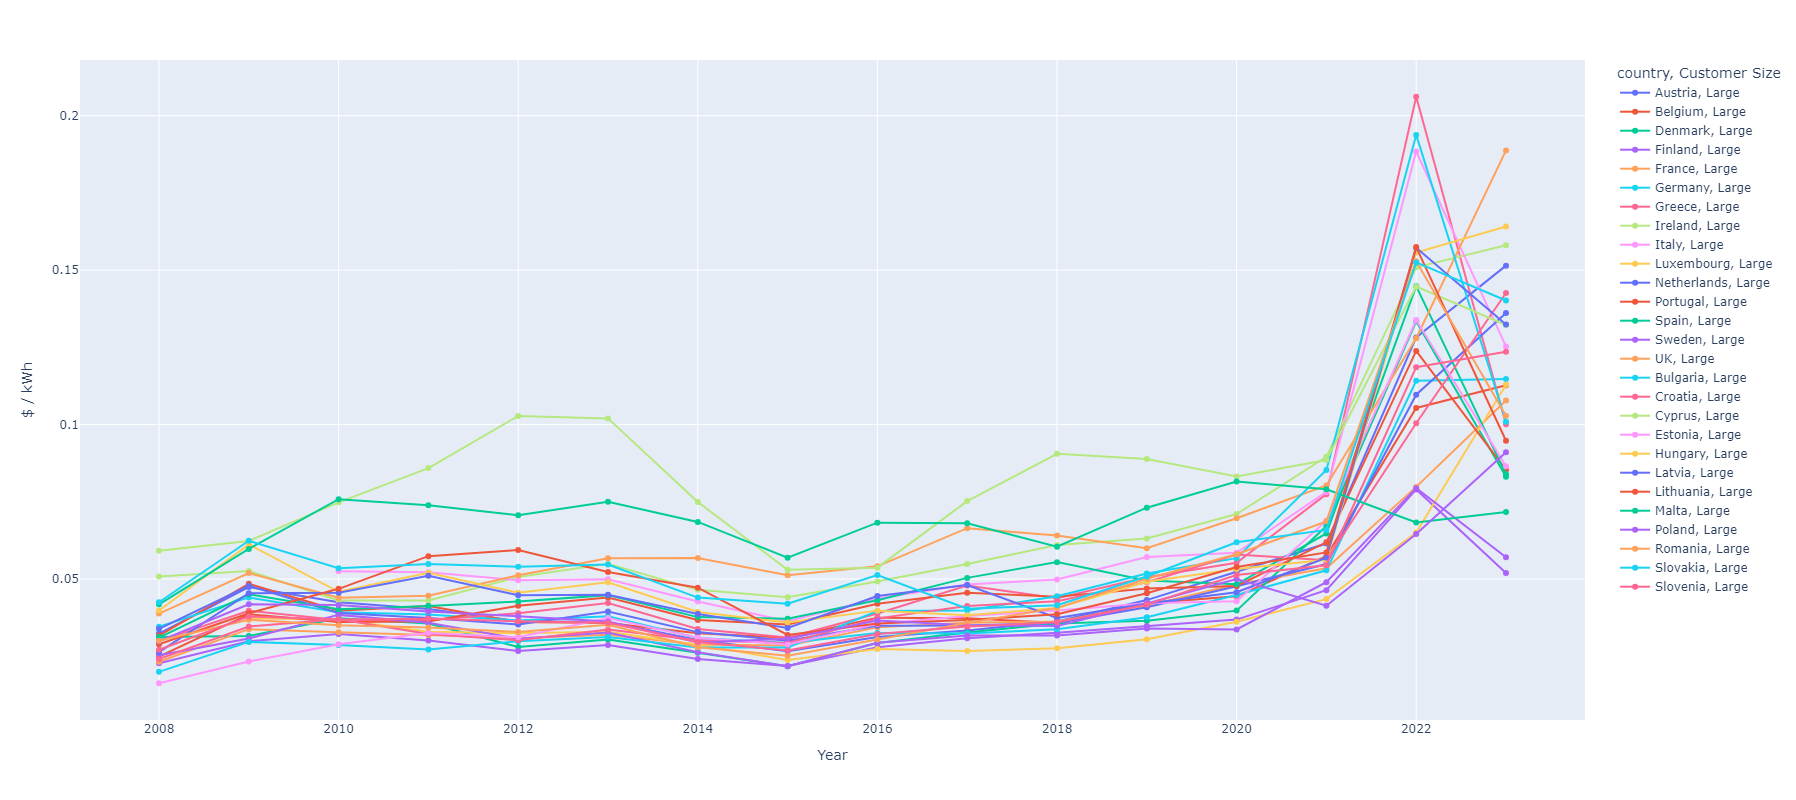

In [202]:
#extract summary sheet
sheet_name = 'Annual excl tax'
anchor_text = 'Source' #last row before table
anchor_col_iloc = 0 #integer

df = sheets[sheet_name].copy()
prices_df = get_data_from_sheet_df(df, anchor_text, anchor_col_iloc)
prices_df = melt_price_df(prices_df)
prices_df = manual_field_removal(prices_df, removal_col='country', identifier_string=' ')
prices_df = add_currency_value(prices_df, exchange_df, currency_country='USA', converted_name='usd_per_kwh')

#export data
print(f"- exporting price data")
did_export = export_electricity_raw_dataset(prices_df,  export_dir, source_dirname='oecd', printer=print)
print(f"- successfully exported price data")


#explore data
customer_sizes = ['Large']
filtered_df = prices_df[prices_df['Customer Size'].isin(customer_sizes)]
fig = px.line(
    filtered_df, 
    x="Year", y="usd_per_kwh", 
    color='country',
    line_dash='Customer Size',
    labels= {
        'usd_per_kwh' : '$ / kWh'
    },
    markers=True,
    height=800, width=1000,
)
fig.update_traces(marker=dict(size=6, symbol='circle'))
display(fig)

# Explore by country

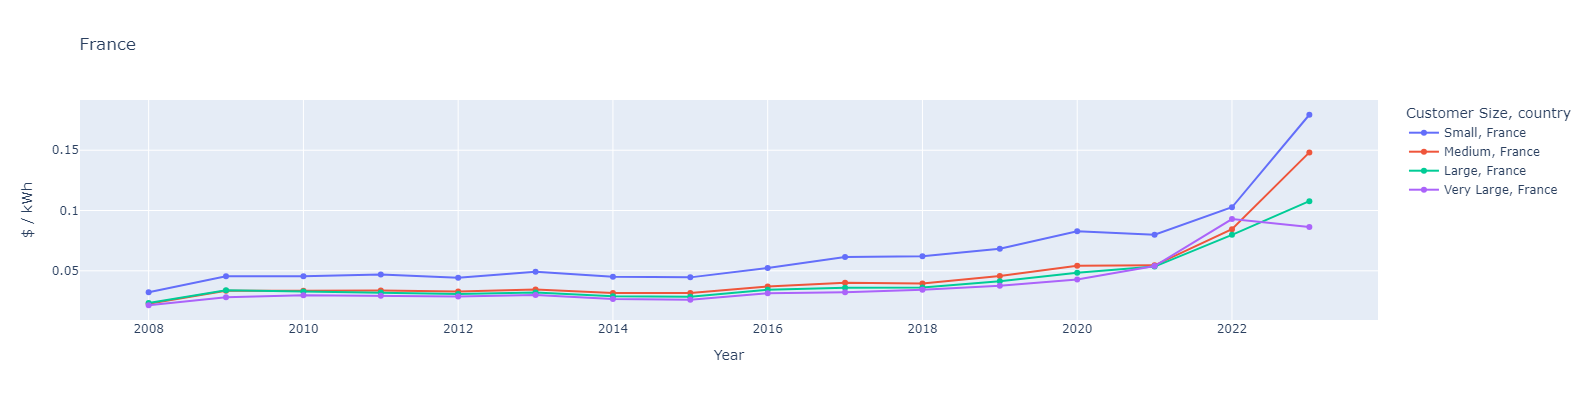

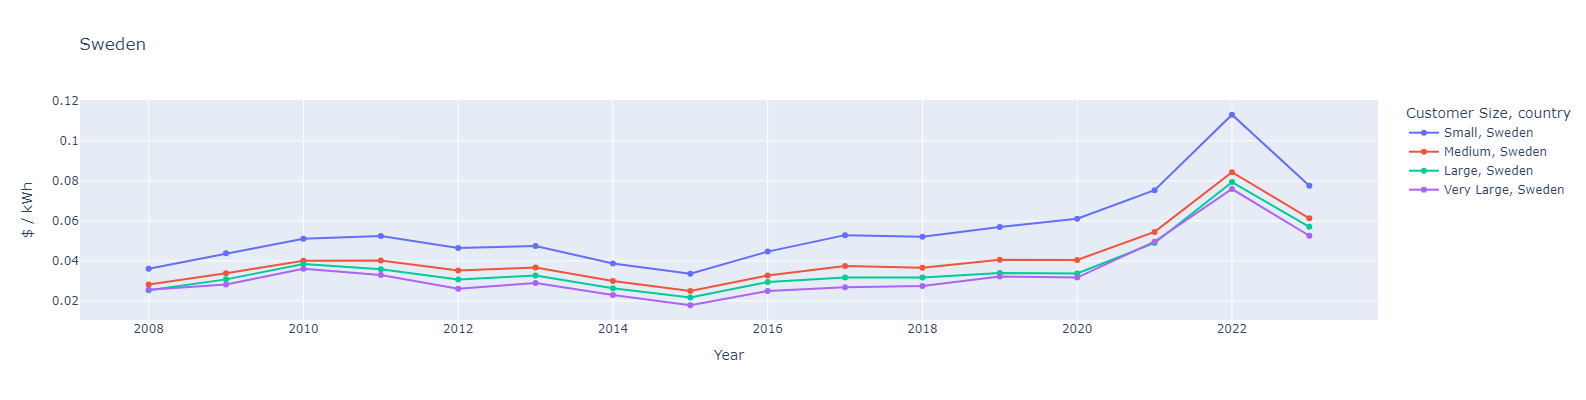

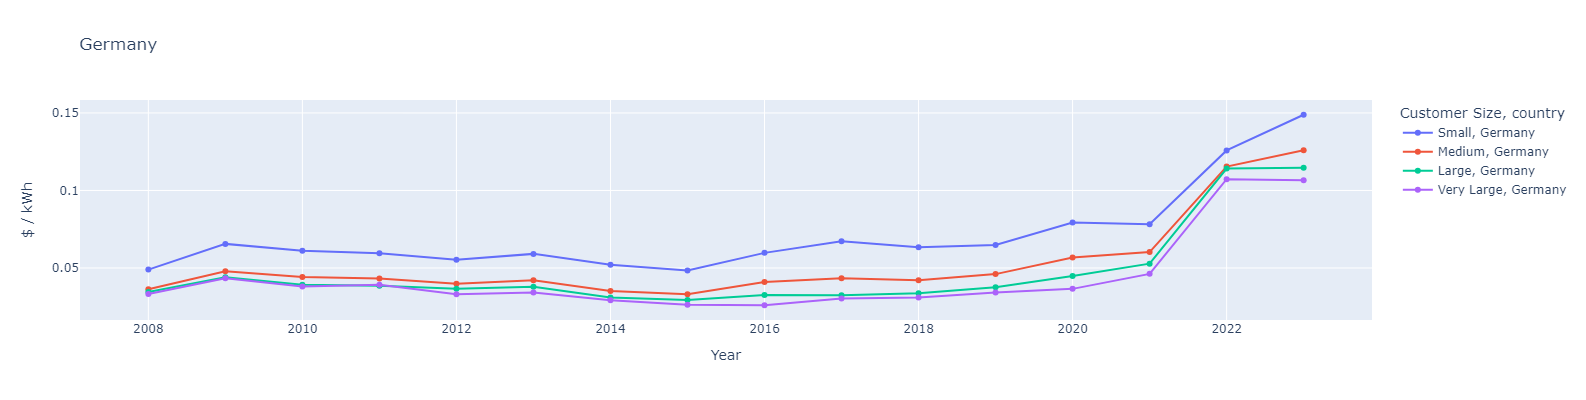

In [212]:
#explore data
countries = ['France','Sweden','Germany']
for country in countries:
    filtered_df = prices_df[prices_df['country'].isin([country])]
    fig = px.line(
        filtered_df, 
        x="Year", y="usd_per_kwh", 
        color='Customer Size',
        line_dash='country',
        labels= {
            'usd_per_kwh' : '$ / kWh'
        },
        markers=True,
        height=400, width=1000,
        title=country.title(),
    )
    fig.update_traces(marker=dict(size=6, symbol='circle'))
    display(fig)